# REAL VARIANT ANALYSIS

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multicomp as mc
from scipy import stats
import pickle
from scipy.stats import mannwhitneyu as mannwu
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import os
from pandas.errors import EmptyDataError
from scipy.stats import false_discovery_control

import sys
sys.path.append("./scripts/modules")

from benchmarking_definitions import *
from plotting import *
from utility_functions import *

In [20]:
final_isolates_depth_comparison_df = pd.read_csv("./data/real_variant_analysis/tags_for_depth_comparison.csv")
final_isolates_depth_comparison_df.shape[0]

20

In [3]:
final_isolates_lineage_comparison_df = pd.read_csv("./data/real_variant_analysis/tags_for_lineage_comparison.csv")
final_isolates_lineage_comparison_df.shape[0]

24

In [4]:
tags = list(pd.read_csv("./data/real_variant_analysis/FINAL_isolates.csv")["tag"].values)
len(tags)

38

In [19]:
isolate_info = pd.read_csv("./data/real_variant_analysis/final_MICML_isolate_list.csv")
isolate_info = isolate_info[isolate_info.tag.isin(tags)].set_index("tag")
isolate_info.head()

,lineage,mean_coverage
tag,,
PE75_COW4699A57_cat,1.0,54.8760
PK00561581,1.0,56.8154
TRL0114477,1.0,99.8792
PE171_S66,1.0,100.9030
20-002-0019,1.0,202.9610


In [6]:
tools_HT = ["FB", "LF", "MT", "VS", "VD"] #for HT mutations

# Check for empty files

In [8]:
source_dir = "/n/data1/hms/dbmi/farhat/shandu/projects/mixed_calls/benchmarking/comprehensive/real_variant_characterization"

LF_source = "{0}/lofreq/output".format(source_dir)
FB_source = "{0}/freebayes/output".format(source_dir)
VD_source = "{0}/vardict/output".format(source_dir)
VS_source = "{0}/varscan01/output".format(source_dir)
MT_source = "{0}/mutect2_bacterialfilteronly/output".format(source_dir)

In [11]:
for tag in tags:
    
    LF_file = "{0}/{1}.lofreq.vcf".format(LF_source, tag)
    FB_file = "{0}/{1}.freebayes.vcf".format(FB_source, tag)
    VD_file = "{0}/{1}.vardict.vcf".format(VD_source, tag)
    VS_file = "{0}/{1}.varscan.tsv".format(VS_source, tag)
    MT_file = "{0}/{1}/{1}.mutect2.microbial_mode.vcf".format(MT_source, tag)
    
    if not os.path.isfile(LF_file):
        print(tag, "no LoFreq")
        LF_df = pd.DataFrame()
    else:
        LF_df = vcf_to_table(LF_file)
    if not os.path.isfile(FB_file):
        print(tag, "no FreeBayes")
        FB_df = pd.DataFrame()
    else:
        FB_df = vcf_to_table(FB_file)
    if not os.path.isfile(VD_file):
        print(tag, "no VarDict")
        VD_df = pd.DataFrame()
    else:
        try:
            VD_df = vcf_to_table(VD_file)
        except EmptyDataError:
            VD_df = pd.DataFrame()
    if not os.path.isfile(VS_file):
        print(tag, "no VarScan2")
        VS_df = pd.DataFrame()
    else:
        VS_df = pd.read_csv(VS_file, sep="\t")
    if not os.path.isfile(MT_file):
        print(tag, "no Mutect2")
        MT_df = pd.DataFrame()
    else:
        MT_df = vcf_to_table(MT_file)
    
    if LF_df.shape[0] < 1:
        print(tag, "empty LoFreq")
    if FB_df.shape[0] < 1:
        print(tag, "empty FreeBayes")
    if VD_df.shape[0] < 1:
        print(tag, "empty VarDict")
    if VS_df.shape[0] < 1:
        print(tag, "empty VarScan2")
    if MT_df.shape[0] < 1:
        print(tag, "empty Mutect2")
    

GA359-450 empty VarDict


# Isolate cohort makeup

## Depths for depth analysis

In [6]:
depth_isolate_info = isolate_info[isolate_info.index.isin(final_isolates_depth_comparison_df.tag.values)]
depth_isolate_info

,lineage,mean_coverage
tag,,
QF00450839,4.0,50.0332
PE159_S8,4.0,50.2834
TRL0044786,4.0,50.4416
C021,4.0,50.4715
FD00214542,4.0,99.7843
DH00748222,4.0,99.8597
PE247_S71,4.0,100.2750
IDR1900043326,4.0,100.3440
FS043A-291,4.0,196.9300


In [10]:
coverage_plot_df = pd.DataFrame(columns=["tag", "mean_coverage", "expected_coverage"])
df_i = 0

for tag in depth_isolate_info.index:
    mean_coverage = depth_isolate_info.loc[tag, "mean_coverage"]
    if mean_coverage < 60:
        expected_coverage = 50
    elif mean_coverage < 120:
        expected_coverage = 100
    elif mean_coverage < 210:
        expected_coverage = 200
    elif mean_coverage < 470:
        expected_coverage = 400
    else:
        expected_coverage = 700

    coverage_plot_df.loc[df_i] = [tag, mean_coverage, expected_coverage]
    df_i += 1

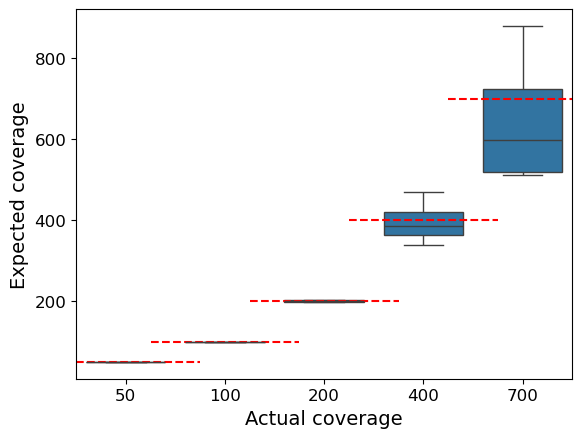

In [11]:
fig, ax = plt.subplots()

sns.boxplot(data=coverage_plot_df, x="expected_coverage", y="mean_coverage", ax=ax)

ax.axhline(50, xmin=0, xmax=0.25, linestyle="--", color="red")
ax.axhline(100, xmin=0.15, xmax=0.45, linestyle="--", color="red")
ax.axhline(200, xmin=0.35, xmax=0.65, linestyle="--", color="red")
ax.axhline(400, xmin=0.55, xmax=0.85, linestyle="--", color="red")
ax.axhline(700, xmin=0.75, xmax=1, linestyle="--", color="red")

ax.tick_params(labelsize=12)
ax.set_ylabel("Expected coverage", fontsize=14)
ax.set_xlabel("Actual coverage", fontsize=14)

file_name = "./figures/real_variant_analysis/depth_comparison_coverages.jpeg"
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

## Lineages for lineage analysis

In [7]:
lineage_isolate_info = isolate_info[isolate_info.index.isin(final_isolates_lineage_comparison_df.tag.values)]
lineage_isolate_info

,lineage,mean_coverage
tag,,
PE75_COW4699A57_cat,1.0,54.8760
PK00561581,1.0,56.8154
TRL0114477,1.0,99.8792
PE171_S66,1.0,100.9030
20-002-0019,1.0,202.9610
GA041-123,1.0,217.6130
C153,2.0,50.3640
19-002-0028,2.0,50.5011
KOR-K2016-0101,2.0,100.0420


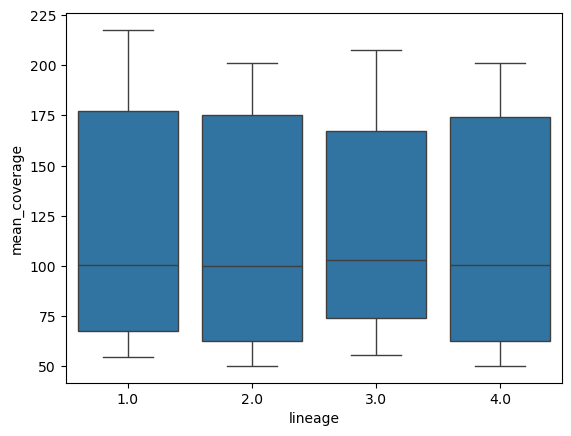

In [14]:
fig, ax = plt.subplots()

sns.boxplot(data=lineage_isolate_info, x="lineage", y="mean_coverage", ax=ax)

file_name = "./figures/real_variant_analysis/lineage_comparison_coverages.jpeg"
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

# [done] Summarize number of variants detected per region for each isolate (AF 5-95%)

In [7]:
source_dir = "/n/scratch/users/s/sm624/benchmarking/variant_summaries/RV"

In [8]:
fixed_thresh = 0.95
lower_thresh = 0.05

DR_mixed_variants_df = pd.DataFrame(columns=["tag", "num_variants"]).set_index("tag")
LM_mixed_variants_df = pd.DataFrame(columns=["tag", "num_variants"]).set_index("tag")
HT_mixed_variants_df = pd.DataFrame(columns=["tag", "num_variants"]).set_index("tag")
other_mixed_variants_df = pd.DataFrame(columns=["tag", "num_variants"]).set_index("tag")

count = 0
for tag in tags:
    
    print(count, end=" ")
    count += 1
    
    variant_summary_df = pd.read_csv("{0}/{1}.variant_summary.csv".format(source_dir, tag), low_memory=False)
    
    DR_num, LM_num, HT_num, other_num = 0, 0, 0, 0
    
    ## DR ##
    DR_summary_df = variant_summary_df[variant_summary_df.REGION_sim == "DR"]
    for i in DR_summary_df.index:
        tool_found = DR_summary_df.loc[i, ["{}_found".format(t) for t in tools]]
        if np.all(tool_found == [1]*len(tools)) or (np.nansum(tool_found) == (len(tools)-1) and np.isnan(DR_summary_df.loc[i, "VD_found"])):
            # if either:
            #  (1) all tools found this variant, or
            #  (2) VarDict did not work for this isolate (determined by the np.nan) and all other tools found this variant
            # this overcomes the issue VarDict had for the isolate GA359-450
            if lower_thresh <= np.nanmean(DR_summary_df.loc[i, ["{}_AF".format(t) for t in tools]]) < fixed_thresh:
                DR_num += 1
    
    
    ## LM ##
    LM_summary_df = variant_summary_df[variant_summary_df.REGION_sim == "LM"]
    for i in LM_summary_df.index:
        tool_found = LM_summary_df.loc[i, ["{}_found".format(t) for t in tools]]
        if np.all(tool_found == [1]*len(tools)) or (np.nansum(tool_found) == (len(tools)-1) and np.isnan(LM_summary_df.loc[i, "VD_found"])):
            # if either:
            #  (1) all tools found this variant, or
            #  (2) VarDict did not work for this isolate (determined by the np.nan) and all other tools found this variant
            # this overcomes the issue VarDict had for the isolate GA359-450
            if lower_thresh <= np.nanmean(LM_summary_df.loc[i, ["{}_AF".format(t) for t in tools]]) < fixed_thresh:
                LM_num += 1
                
    
    ## other ##
    other_summary_df = variant_summary_df[variant_summary_df.REGION_sim == "other"]
    for i in other_summary_df.index:
        tool_found = other_summary_df.loc[i, ["{}_found".format(t) for t in tools]]
        if np.all(tool_found == [1]*len(tools)) or (np.nansum(tool_found) == (len(tools)-1) and np.isnan(other_summary_df.loc[i, "VD_found"])):
            # if either:
            #  (1) all tools found this variant, or
            #  (2) VarDict did not work for this isolate (determined by the np.nan) and all other tools found this variant
            # this overcomes the issue VarDict had for the isolate GA359-450
            if lower_thresh <= np.nanmean(other_summary_df.loc[i, ["{}_AF".format(t) for t in tools]]) < fixed_thresh:
                other_num += 1

               
    DR_mixed_variants_df.loc[tag] = DR_num
    LM_mixed_variants_df.loc[tag] = LM_num
    other_mixed_variants_df.loc[tag] = other_num
        
        


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 

In [9]:
DR_mixed_variants_df.to_csv("./data/real_variant_analysis/DR_all_tools_mixed_variants.csv")
LM_mixed_variants_df.to_csv("./data/real_variant_analysis/LM_all_tools_mixed_variants.csv")
other_mixed_variants_df.to_csv("./data/real_variant_analysis/other_all_tools_mixed_variants.csv")

## HT run to include only 1 base insertions

In [10]:
fixed_thresh = 0.95
lower_thresh = 0.05

HT_mixed_variants_df = pd.DataFrame(columns=["tag", "num_variants"]).set_index("tag")

count = 0
for tag in tags:
    
    print(count, end=" ")
    count += 1
    
    variant_summary_df = pd.read_csv("{0}/{1}.variant_summary.csv".format(source_dir, tag), low_memory=False)
    
    HT_num = 0
                
    ## HT ##
    HT_summary_df = variant_summary_df[variant_summary_df.REGION_sim == "HT"]
    for i in HT_summary_df.index:
        if len(HT_summary_df.loc[i, "REF"]) == 1 and len(HT_summary_df.loc[i, "ALT"]) == 2:
            tool_found = HT_summary_df.loc[i, ["{}_found".format(t) for t in tools_HT]] #do not include Pilon
            if np.all(tool_found == [1]*len(tools_HT)) or (np.nansum(tool_found) == (len(tools_HT)-1) and np.isnan(HT_summary_df.loc[i, "VD_found"])):
                # if either:
                #  (1) all tools except Pilon found this variant, or
                #  (2) VarDict did not work for this isolate (determined by the np.nan) and all other tools except Pilon found this variant
                # this overcomes the issue VarDict had for the isolate GA359-450
                if lower_thresh <= np.nanmean(HT_summary_df.loc[i, ["{}_AF".format(t) for t in tools]]) < fixed_thresh:
                    HT_num += 1

               

    HT_mixed_variants_df.loc[tag] = HT_num

        
        


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 

In [11]:
HT_mixed_variants_df.to_csv("./data/real_variant_analysis/HT_all_tools_mixed_variants.csv")

# [done] Compare number of variants detected in each region between isolates in each sequencing depth group

In [8]:
DR_mixed_variants_df = pd.read_csv("./data/real_variant_analysis/DR_all_tools_mixed_variants.csv").set_index("tag")
LM_mixed_variants_df = pd.read_csv("./data/real_variant_analysis/LM_all_tools_mixed_variants.csv").set_index("tag")
other_mixed_variants_df = pd.read_csv("./data/real_variant_analysis/other_all_tools_mixed_variants.csv").set_index("tag")
HT_mixed_variants_df = pd.read_csv("./data/real_variant_analysis/HT_all_tools_mixed_variants.csv").set_index("tag")

## Plot distribution of number of variants found per depth in each region

In [9]:
region_by_depth_df = pd.DataFrame(columns=["tag", "depth", "region", "num_variants"])
df_i = 0

for tag in final_isolates_depth_comparison_df.tag.values:

    mean_coverage = isolate_info.loc[tag, "mean_coverage"]

    if mean_coverage < 60:
        depth = 50
    elif mean_coverage < 120:
        depth = 100
    elif mean_coverage < 210:
        depth = 200
    elif mean_coverage < 470:
        depth = 400
    else:
        depth = 700

    num_DR_variants = DR_mixed_variants_df.loc[tag, "num_variants"]
    num_LM_variants = LM_mixed_variants_df.loc[tag, "num_variants"]
    num_other_variants = other_mixed_variants_df.loc[tag, "num_variants"]
    num_HT_variants = HT_mixed_variants_df.loc[tag, "num_variants"]

    region_by_depth_df.loc[df_i] = [tag, depth, "DR", num_DR_variants]
    df_i += 1
    region_by_depth_df.loc[df_i] = [tag, depth, "LM", num_LM_variants]
    df_i += 1
    region_by_depth_df.loc[df_i] = [tag, depth, "other", num_other_variants]
    df_i += 1
    region_by_depth_df.loc[df_i] = [tag, depth, "HT", num_HT_variants]
    df_i += 1

<Axes: xlabel='depth', ylabel='num_variants'>

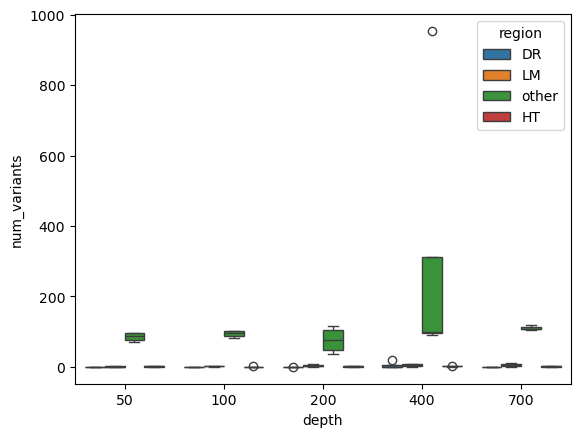

In [10]:
fig, ax = plt.subplots()

sns.boxplot(data=region_by_depth_df, x="depth", y="num_variants", hue="region")

In [14]:
depth_combos = list(combinations(depths, 2))

all_results_df = pd.DataFrame(columns=["region", "p1", "p2", "p2-p1", "test_stat", "p_val"])
df_i = 0

for region in regions_other:

    region_df = region_by_depth_df[region_by_depth_df.region == region]

    for p1, p2 in depth_combos:
    
        p1_values = region_df[region_df.depth == p1]["num_variants"].values
        p2_values = region_df[region_df.depth == p2]["num_variants"].values
    
        p1_mean = np.mean(p1_values)
        p2_mean = np.mean(p2_values)
    
        test_result = mannwu(p1_values, p2_values)
    
        all_results_df.loc[df_i] = [region, p1, p2, p2_mean-p1_mean, test_result[0], test_result[1]]
        df_i += 1

raw_pvalues = all_results_df.p_val.values
corrected_pvals = false_discovery_control(raw_pvalues, method='bh')

all_results_df["corrected_p_val"] = corrected_pvals
all_results_df["decision"] = (np.array(corrected_pvals) <= 0.05).astype(int)

all_results_df


,region,p1,p2,p2-p1,test_stat,p_val,corrected_p_val,decision
0,DR,50,100,-0.50,12.0,0.181358,0.725433,0
1,DR,50,200,-0.25,10.0,0.608408,0.884156,0
2,DR,50,400,4.25,9.0,0.867632,1.000000,0
3,DR,50,700,-0.50,12.0,0.181358,0.725433,0
4,DR,100,200,0.25,6.0,0.453255,0.824099,0
5,DR,100,400,4.75,6.0,0.453255,0.824099,0
6,DR,100,700,0.00,8.0,1.000000,1.000000,0
7,DR,200,400,4.50,7.5,1.000000,1.000000,0
8,DR,200,700,-0.25,10.0,0.453255,0.824099,0
9,DR,400,700,-4.75,10.0,0.453255,0.824099,0


# [done] Compare number of variants detected in each region between isolates from different lineages

## Plot distribution of number of variants found per lineage in each region

In [15]:
region_by_lineage_df = pd.DataFrame(columns=["tag", "lineage", "region", "num_variants"])
df_i = 0

for tag in final_isolates_lineage_comparison_df.tag.values:

    lineage = isolate_info.loc[tag, "lineage"]

    num_DR_variants = DR_mixed_variants_df.loc[tag, "num_variants"]
    num_LM_variants = LM_mixed_variants_df.loc[tag, "num_variants"]
    num_other_variants = other_mixed_variants_df.loc[tag, "num_variants"]
    num_HT_variants = HT_mixed_variants_df.loc[tag, "num_variants"]

    region_by_lineage_df.loc[df_i] = [tag, lineage, "DR", num_DR_variants]
    df_i += 1
    region_by_lineage_df.loc[df_i] = [tag, lineage, "LM", num_LM_variants]
    df_i += 1
    region_by_lineage_df.loc[df_i] = [tag, lineage, "other", num_other_variants]
    df_i += 1
    region_by_lineage_df.loc[df_i] = [tag, lineage, "HT", num_HT_variants]
    df_i += 1

<Axes: xlabel='lineage', ylabel='num_variants'>

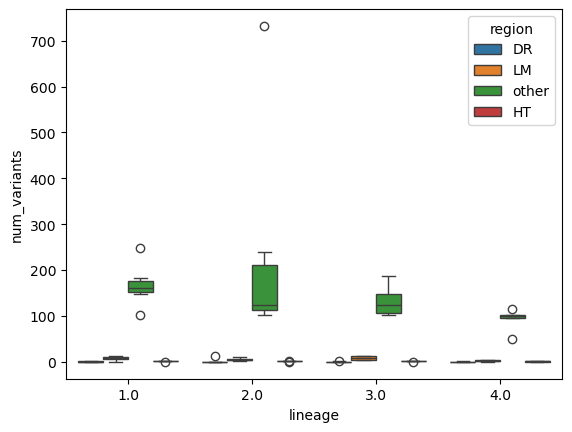

In [16]:
fig, ax = plt.subplots()

sns.boxplot(data=region_by_lineage_df, x="lineage", y="num_variants", hue="region")

In [17]:
lineage_combos = list(combinations(range(1, 5), 2))

all_results_df = pd.DataFrame(columns=["region", "p1", "p2", "p2-p1", "test_stat", "p_val"])
df_i = 0

for region in regions_other:

    region_df = region_by_lineage_df[region_by_lineage_df.region == region]

    for p1, p2 in lineage_combos:
    
        p1_values = region_df[region_df.lineage == p1]["num_variants"].values
        p2_values = region_df[region_df.lineage == p2]["num_variants"].values
    
        p1_mean = np.mean(p1_values)
        p2_mean = np.mean(p2_values)
    
        test_result = mannwu(p1_values, p2_values)
    
        all_results_df.loc[df_i] = [region, p1, p2, p2_mean-p1_mean, test_result[0], test_result[1]]
        df_i += 1

raw_pvalues = all_results_df.p_val.values
corrected_pvals = false_discovery_control(raw_pvalues, method='bh')

all_results_df["corrected_p_val"] = corrected_pvals
all_results_df["decision"] = (np.array(corrected_pvals) <= 0.05).astype(int)

all_results_df


,region,p1,p2,p2-p1,test_stat,p_val,corrected_p_val,decision
0,DR,1,2,1.166667,22.5,0.444847,0.821256,0
1,DR,1,3,-0.333333,21.5,0.588092,0.852111,0
2,DR,1,4,-0.500000,23.0,0.416560,0.821256,0
3,DR,2,3,-1.500000,16.0,0.752554,0.860061,0
4,DR,2,4,-1.666667,16.0,0.751830,0.860061,0
5,DR,3,4,-0.166667,19.0,0.923342,0.963487,0
6,HT,1,2,0.166667,15.5,0.673290,0.852111,0
7,HT,1,3,0.833333,8.0,0.100956,0.403823,0
8,HT,1,4,0.500000,13.5,0.489800,0.839658,0
9,HT,2,3,0.666667,10.0,0.203420,0.542454,0


# [done] Summarize median number of variants found in each region for weighted F1 analysis

In [12]:
DR_mixed_variants_df = pd.read_csv("./data/real_variant_analysis/DR_all_tools_mixed_variants.csv").set_index("tag")
LM_mixed_variants_df = pd.read_csv("./data/real_variant_analysis/LM_all_tools_mixed_variants.csv").set_index("tag")
other_mixed_variants_df = pd.read_csv("./data/real_variant_analysis/other_all_tools_mixed_variants.csv").set_index("tag")
HT_mixed_variants_df = pd.read_csv("./data/real_variant_analysis/HT_all_tools_mixed_variants.csv").set_index("tag")

In [13]:
region_df = pd.DataFrame(columns=["tag", "region", "num_variants"])
df_i = 0

for tag in tags:

    num_DR_variants = DR_mixed_variants_df.loc[tag, "num_variants"]
    num_LM_variants = LM_mixed_variants_df.loc[tag, "num_variants"]
    num_other_variants = other_mixed_variants_df.loc[tag, "num_variants"]
    num_HT_variants = HT_mixed_variants_df.loc[tag, "num_variants"]

    region_df.loc[df_i] = [tag, "DR", num_DR_variants]
    df_i += 1
    region_df.loc[df_i] = [tag, "LM", num_LM_variants]
    df_i += 1
    region_df.loc[df_i] = [tag, "other", num_other_variants]
    df_i += 1
    region_df.loc[df_i] = [tag, "HT", num_HT_variants]
    df_i += 1

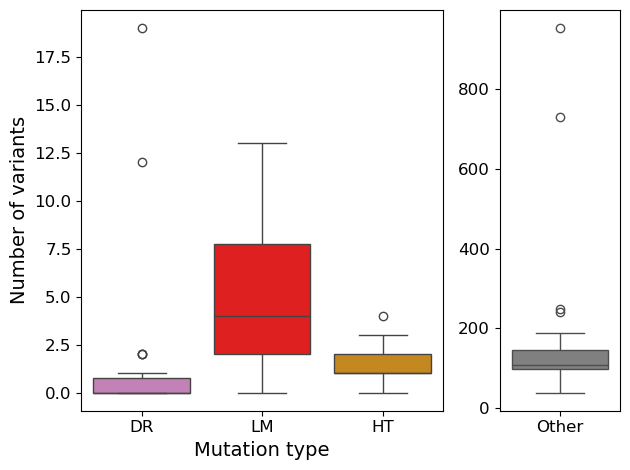

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

sns.boxplot(data=region_df[region_df.region != "other"], hue="region",
            x="region", y="num_variants", palette=region_colors, ax=ax1)

sns.boxplot(data=region_df[region_df.region == "other"],
            y="num_variants", color="grey", ax=ax2)

ax1.set_xlabel("Mutation type", fontsize=14)
ax1.set_ylabel("Number of variants", fontsize=14)
ax1.tick_params(labelsize=12)

ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(["Other"])
ax2.set_ylabel("")
ax2.tick_params(labelsize=12)

plt.tight_layout()

plt.show()

In [15]:
print("DR+other:", 
      region_df[region_df.region == "DR"]["num_variants"].median(), 
      region_df[region_df.region == "other"]["num_variants"].median())

print("LM:", 
      region_df[region_df.region == "LM"]["num_variants"].median())

print("HT:", 
      region_df[region_df.region == "HT"]["num_variants"].median())

DR+other: 0.0 106.0
LM: 4.0
HT: 1.0


# [done] Mutect2 call labels

In [5]:
source_dir = "/n/scratch/users/s/sm624/benchmarking/variant_summaries/RV"

In [12]:
seen_filter_labels = {}

count = 0
for tag in tags:
    
    if count % 10 == 0:
        print(count, end=" ")
    count += 1
    
    variant_summary_df = pd.read_csv("{0}/{1}.variant_summary.csv".format(source_dir, tag), low_memory=False)

    for i in variant_summary_df.index:
        tool_found = variant_summary_df.loc[i, ["{}_found".format(t) for t in tools]]
        if np.all(tool_found == [1]*len(tools)) or (np.nansum(tool_found) == (len(tools)-1) and np.isnan(variant_summary_df.loc[i, "VD_found"])):
            # if either:
            #  (1) all tools found this variant, or
            #  (2) VarDict did not work for this isolate (determined by the np.nan) and all other tools found this variant
            # this overcomes the issue VarDict had for the isolate GA359-450
            
            MT_filter = variant_summary_df.loc[i, "MT_FILTER"]

            if MT_filter not in seen_filter_labels:
                seen_filter_labels[MT_filter] = 1
            else:
                seen_filter_labels[MT_filter] += 1

seen_filter_labels

0 10 20 30 

{'PASS': 51073, nan: 1193, 'orientation': 35}

In [14]:
(35/(51073+1193+35))*100

0.06692032657119366

# Excess variants at specific depths

In [21]:
depth_isolate_info = isolate_info[isolate_info.index.isin(final_isolates_depth_comparison_df.tag.values)]
coverage_df = pd.DataFrame(columns=["tag", "mean_coverage", "expected_coverage"])
df_i = 0

for tag in depth_isolate_info.index:
    mean_coverage = depth_isolate_info.loc[tag, "mean_coverage"]
    if mean_coverage < 60:
        expected_coverage = 50
    elif mean_coverage < 120:
        expected_coverage = 100
    elif mean_coverage < 210:
        expected_coverage = 200
    elif mean_coverage < 470:
        expected_coverage = 400
    else:
        expected_coverage = 700

    coverage_df.loc[df_i] = [tag, mean_coverage, expected_coverage]
    df_i += 1
coverage_df

,tag,mean_coverage,expected_coverage
0,QF00450839,50.0332,50
1,PE159_S8,50.2834,50
2,TRL0044786,50.4416,50
3,C021,50.4715,50
4,FD00214542,99.7843,100
5,DH00748222,99.8597,100
6,PE247_S71,100.2750,100
7,IDR1900043326,100.3440,100
8,FS043A-291,196.9300,200
9,FS512-284,198.6080,200


In [22]:
var_by_tool_df = pd.DataFrame(columns=["tag", "depth", "num_var", "Tool"])
df_i = 0

source_dir = "/n/scratch/users/s/sm624/benchmarking/variant_summaries/RV"

count = 0
for depth in depths:
    
    depth_df = coverage_df[coverage_df.expected_coverage == depth]
    
    for i in depth_df.index:
        
        count += 1
        print(count, end=" ")
        
        tag = depth_df.loc[i, "tag"]
        summary_df = pd.read_csv("{0}/{1}.variant_summary.csv".format(source_dir, tag), low_memory=False)
        
        for tool in tools:
            tool_df = summary_df[summary_df["{}_found".format(tool)] == 1]
            num_var = tool_df.shape[0]
            var_by_tool_df.loc[df_i] = [tag, depth, num_var, tool_mapping[tool]]
            df_i += 1


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

In [24]:
var_by_tool_df

,tag,depth,num_var,Tool
0,QF00450839,50,10328,FreeBayes
1,QF00450839,50,1359,LoFreq
2,QF00450839,50,1886,Mutect2
3,QF00450839,50,8811,Pilon
4,QF00450839,50,6449,VarDict
...,...,...,...,...
115,GA359-450,700,1578,LoFreq
116,GA359-450,700,1471,Mutect2
117,GA359-450,700,26762,Pilon
118,GA359-450,700,0,VarDict


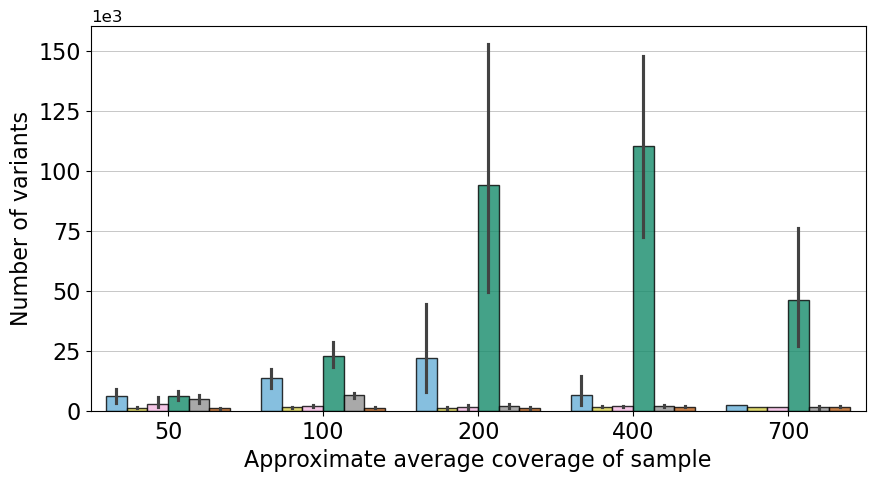

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.grid(axis="y", linewidth=0.5, zorder=0)

sns.barplot(data=var_by_tool_df, x="depth", y="num_var", hue="Tool", errorbar="ci", palette=tool_colors_, 
            edgecolor="black", alpha=0.8, legend=False, ax=ax, zorder=2)

ax.set_xlabel("Approximate average coverage of sample", fontsize=16)
ax.set_ylabel("Number of variants", fontsize=16)

ax.tick_params(labelsize=16)

ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))

ax.yaxis.get_offset_text().set_fontsize(12)

file_name = "./figures/real_variant_analysis/number_of_variants_by_depth.jpeg"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

file_name = "./figures/real_variant_analysis/number_of_variants_by_depth.pdf"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

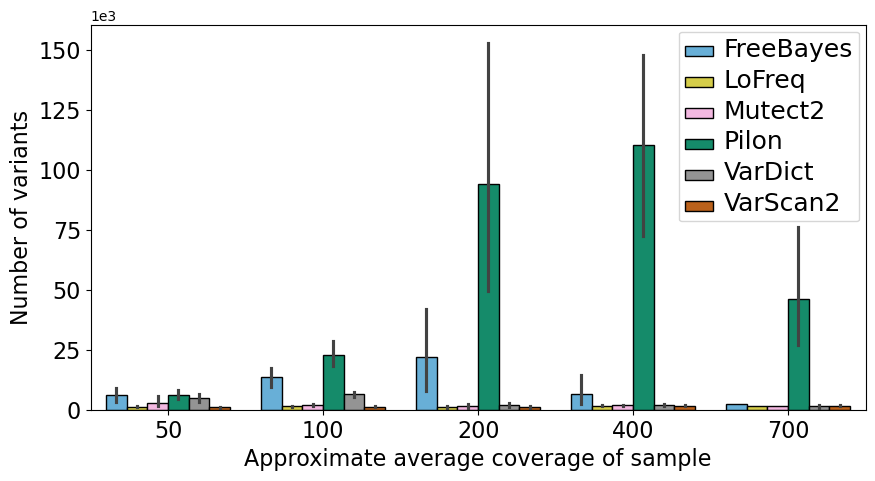

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(data=var_by_tool_df, x="depth", y="num_var", hue="Tool", errorbar="ci", palette=tool_colors_, 
            edgecolor="black", legend=True, ax=ax, zorder=2)

ax.set_xlabel("Approximate average coverage of sample", fontsize=16)
ax.set_ylabel("Number of variants", fontsize=16)

ax.tick_params(labelsize=16)

plt.setp(ax.get_legend().get_texts(), fontsize='18')
ax.get_legend().set_title("")

ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))

file_name = "./figures/real_variant_analysis/tool_box_legend.jpeg"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

file_name = "./figures/real_variant_analysis/tool_box_legend.pdf"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()